# Lab 3 - Convergence analysis of the upwind scheme

### Tomasz Ogiołda

## Goal

The goal of the convergence analysis is to evaluate the accuracy of a numerical solution as the resolution of the discretization is refined. Specifically, the analysis will explore spatial convergence (how the solution improves with decreasing grid spacing dx).

## Setup

The problem involves the advection of an initial condition (represented by a Gaussian function) over time. The numerical method used to solve this advection equation is the upwind scheme, which is an explicit finite difference method. For stability, we will maintain a constant Courant number (CFL), ensuring that the time step dt and spatial step dx are related according to the CFL condition:

$$C= v \cdot \frac{\Delta t}{\Delta x}$$

In the following analysis we'll consider constants of Courant numer. Keeping the CFL constant per analysis allows us to maintain a consistent physical representation across different grid resolutions.

The error will be quantified using the Root Mean Square Error (RMSE):

$$\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left( u_i^{\text{num}} - u_i^{\text{exact}} \right)^2}$$



In [1]:
import numpy as np
from matplotlib import pyplot as plt

%config InlineBackend.figure_formats = ['svg']

In [2]:
def rmse(numerical: np.ndarray, expected: np.ndarray):
    assert len(numerical) == len(expected), "Actual and Expected value len not matched"
    
    return np.sqrt(np.mean((numerical - expected)**2))

In [3]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25

    def __call__(self, x) -> float:
        return self.a * np.exp(-(x - self.x0)**2 / (2 * self.sigma**2))

class SliceStep:
    def __init__(self, step) -> None:
        self.step = step
    
    def __radd__(self, o: slice):
        return slice(o.start + self.step, o.stop + self.step)
    
    def __rsub__(self, o: slice):
        return slice(o.start - self.step, o.stop - self.step)
    
    
def Flux(psi_L, psi_R, C):
    return (C + abs(C)) / 2 * psi_L + (C - abs(C)) / 2 * psi_R

In [4]:
u = 2
t_max = 50
psi_0 = Psi_0()

def upwind_scheme(x, C, dx, nx):
    one = SliceStep(1)
    dt = C * dx / u
    nt = int(t_max / dt)
    psi = psi_0(x)

    i = slice(1, nx - 2)

    for _ in range(nt):
        psi_new = psi.copy()
        psi_new[i] = psi[i] - (Flux(psi[i], psi[i + one], C) - Flux(psi[i - one], psi[i], C))
        psi = psi_new
        
    return psi

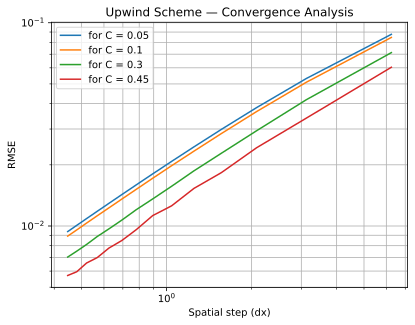

In [5]:
nxs =  64 * np.arange(1, 15)

def upwind_err(nx, C):
    x, dx = np.linspace(-100, 300, nx, retstep=True, endpoint=False)
    
    exact = psi_0(x - u * t_max)
    numerical = upwind_scheme(x, C, dx, nx)
    
    return dx, rmse(numerical=numerical, expected=exact)

def err_per_c(C):
    errs = [upwind_err(nx, C) for nx in nxs]
    x, y = zip(*errs)
    
    return x, y

e4 = err_per_c(0.05)
e3 = err_per_c(0.1)
e2 = err_per_c(0.3)
e1 = err_per_c(0.45)

plt.loglog(e4[0], e4[1], label='for C = 0.05')
plt.loglog(e3[0], e3[1], label='for C = 0.1')
plt.loglog(e2[0], e2[1], label='for C = 0.3')
plt.loglog(e1[0], e1[1], label='for C = 0.45')
plt.title("Upwind Scheme — Convergence Analysis")
plt.xlabel('Spatial step (dx)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, which='both')

## Conclusions 

Decreasing the spatial step (dx) in the upwind scheme consistently reduces numerical error across all Courant numbers, confirming first-order convergence behavior. However, this relationship varies significantly with different Courant numbers, with higher values (particularly C = 0.45) showing more efficient error reduction as dx decreases. While grid refinement improves accuracy, diminishing returns are observed at very small spatial steps (dx < 10^-3), indicating that computational efficiency should be balanced against desired accuracy when selecting discretization parameters.
